In [1]:
import sys
sys.executable


'c:\\Users\\devma\\Projetos\\customer-retention-analytics\\.venv\\Scripts\\python.exe'

## Iniciando Analise Trimestral sem Anomalias

In [6]:
import os
import pandas as pd
import urllib.parse
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
# 1. Carregar variáveis de ambiente (DEVE vir primeiro)
load_dotenv()

# 2. Configuração das credenciais
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POSTGRES_PORT", "5432")

conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

try:
    with engine.connect() as conn:
        df_churn_trimestral = pd.read_sql(text(sql_query), conn)

    print("✅ Sucesso! Os dados foram carregados em 'df_churn_anual'.")
    print(df_churn_trimestral.head())

except Exception as e:
    print(f" Erro ao executar consulta: {e}")

# 1. Carregar variáveis de ambiente do arquivo .env
load_dotenv()

# 2. Configuração das credenciais com tratamento para caracteres especiais (como o '@')
# Mude apenas esta parte do código anterior:
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POSTGRES_PORT", "5432") # A porta costuma ser a mesma
# 3. Construção da URL de conexão e criação do Engine
conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

# 4. Definição da sua Query SQL de Churn Anual
sql_query = """
WITH base_contratos AS (
    SELECT DISTINCT
        c.nr_central_sigma,
        ccc.codigo_contrato,
        ccc.data_pedido AS data_inicio,
        ccc.data_rescisao,
        (
            SELECT mcc.situacao
            FROM movimento_contratos_cli mcc
            WHERE mcc.codigo_contrato = ccc.codigo_contrato
              AND mcc.situacao <> 7
            ORDER BY mcc.data_conclusao DESC
            LIMIT 1
        ) AS situacao_movimento
    FROM clientes c
    INNER JOIN cab_contratos_cli ccc 
        ON ccc.codigo_cliente = c.codigo_cliente
),

clientes_com_contrato_ativo AS (
    SELECT DISTINCT nr_central_sigma
    FROM base_contratos
    WHERE data_rescisao IS NULL
),

churn_por_cliente AS (
    SELECT
        bc.nr_central_sigma,
        MAX(bc.data_rescisao) AS data_churn
    FROM base_contratos bc
    WHERE bc.data_rescisao IS NOT NULL
      AND bc.nr_central_sigma NOT IN (
            SELECT nr_central_sigma FROM clientes_com_contrato_ativo
      )
    GROUP BY bc.nr_central_sigma
),

-- 📅 Calendário fixo trimestral de 2015 a 2025
calendario_trimestres AS (
    SELECT generate_series(
        DATE '2015-01-01',
        DATE '2025-12-31',
        INTERVAL '3 months'
    )::date AS trimestre
),

churn_trimestral AS (
    SELECT
        DATE_TRUNC('quarter', ch.data_churn) AS trimestre_churn,
        COUNT(DISTINCT ch.nr_central_sigma) AS clientes_churn
    FROM churn_por_cliente ch
    WHERE ch.data_churn BETWEEN '2015-01-01' AND '2025-12-31'
    GROUP BY 1
),

clientes_ativos_inicio_trimestre AS (
    SELECT
        ct.trimestre,
        COUNT(DISTINCT bc.nr_central_sigma) AS total_clientes_inicio
    FROM calendario_trimestres ct
    LEFT JOIN base_contratos bc
        ON bc.data_inicio < ct.trimestre
       AND (bc.data_rescisao IS NULL OR bc.data_rescisao >= ct.trimestre)
    GROUP BY ct.trimestre
)

SELECT
    CONCAT(
        EXTRACT(YEAR FROM cat.trimestre),
        '-Q',
        EXTRACT(QUARTER FROM cat.trimestre)
    ) AS periodo_trimestral,

    cat.total_clientes_inicio AS clientes_inicio_trimestre,
    COALESCE(ct.clientes_churn, 0) AS total_churn_no_trimestre,

    ROUND(
        (COALESCE(ct.clientes_churn,0)::numeric 
        / NULLIF(cat.total_clientes_inicio,0)::numeric) * 100
    ,2) AS churn_rate_trimestral_percentual,

    CASE 
        WHEN (COALESCE(ct.clientes_churn,0)::numeric / NULLIF(cat.total_clientes_inicio,0)) * 100 > 6 THEN 'CRÍTICO (>6%)'
        WHEN (COALESCE(ct.clientes_churn,0)::numeric / NULLIF(cat.total_clientes_inicio,0)) * 100 > 4.5 THEN 'ALERTA'
        ELSE 'DENTRO DA META'
    END AS analise_saude

FROM clientes_ativos_inicio_trimestre cat
LEFT JOIN churn_trimestral ct 
       ON cat.trimestre = ct.trimestre_churn

WHERE cat.trimestre BETWEEN '2015-01-01' AND '2025-12-31'
ORDER BY cat.trimestre;

"""

# 5. Execução e salvamento no DataFrame df_churn_anual
try:
    df_churn_trimestral = pd.read_sql(sql_query, engine)
    print(" Sucesso! Os dados foram carregados em 'df_churn_anual'.")
    
    # Exibir as primeiras linhas para conferência
    print(df_churn_trimestral.head())

except Exception as e:
    print(f" Erro ao executar consulta: {e}")

✅ Sucesso! Os dados foram carregados em 'df_churn_anual'.
  periodo_trimestral  clientes_inicio_trimestre  total_churn_no_trimestre  \
0            2015-Q1                       4314                       242   
1            2015-Q2                       4374                       254   
2            2015-Q3                       4427                       229   
3            2015-Q4                       4588                       223   
4            2016-Q1                       4679                       231   

   churn_rate_trimestral_percentual analise_saude  
0                              5.61        ALERTA  
1                              5.81        ALERTA  
2                              5.17        ALERTA  
3                              4.86        ALERTA  
4                              4.94        ALERTA  
 Erro ao executar consulta: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence


### Visualizando a Base

In [7]:
df_churn_trimestral

,periodo_trimestral,clientes_inicio_trimestre,total_churn_no_trimestre,churn_rate_trimestral_percentual,analise_saude
0,2015-Q1,4314,242,5.61,ALERTA
1,2015-Q2,4374,254,5.81,ALERTA
2,2015-Q3,4427,229,5.17,ALERTA
3,2015-Q4,4588,223,4.86,ALERTA
4,2016-Q1,4679,231,4.94,ALERTA
5,2016-Q2,4778,249,5.21,ALERTA
6,2016-Q3,4814,236,4.90,ALERTA
7,2016-Q4,4716,232,4.92,ALERTA
8,2017-Q1,4562,200,4.38,DENTRO DA META
9,2017-Q2,4448,188,4.23,DENTRO DA META


#### Visualizando Grafico

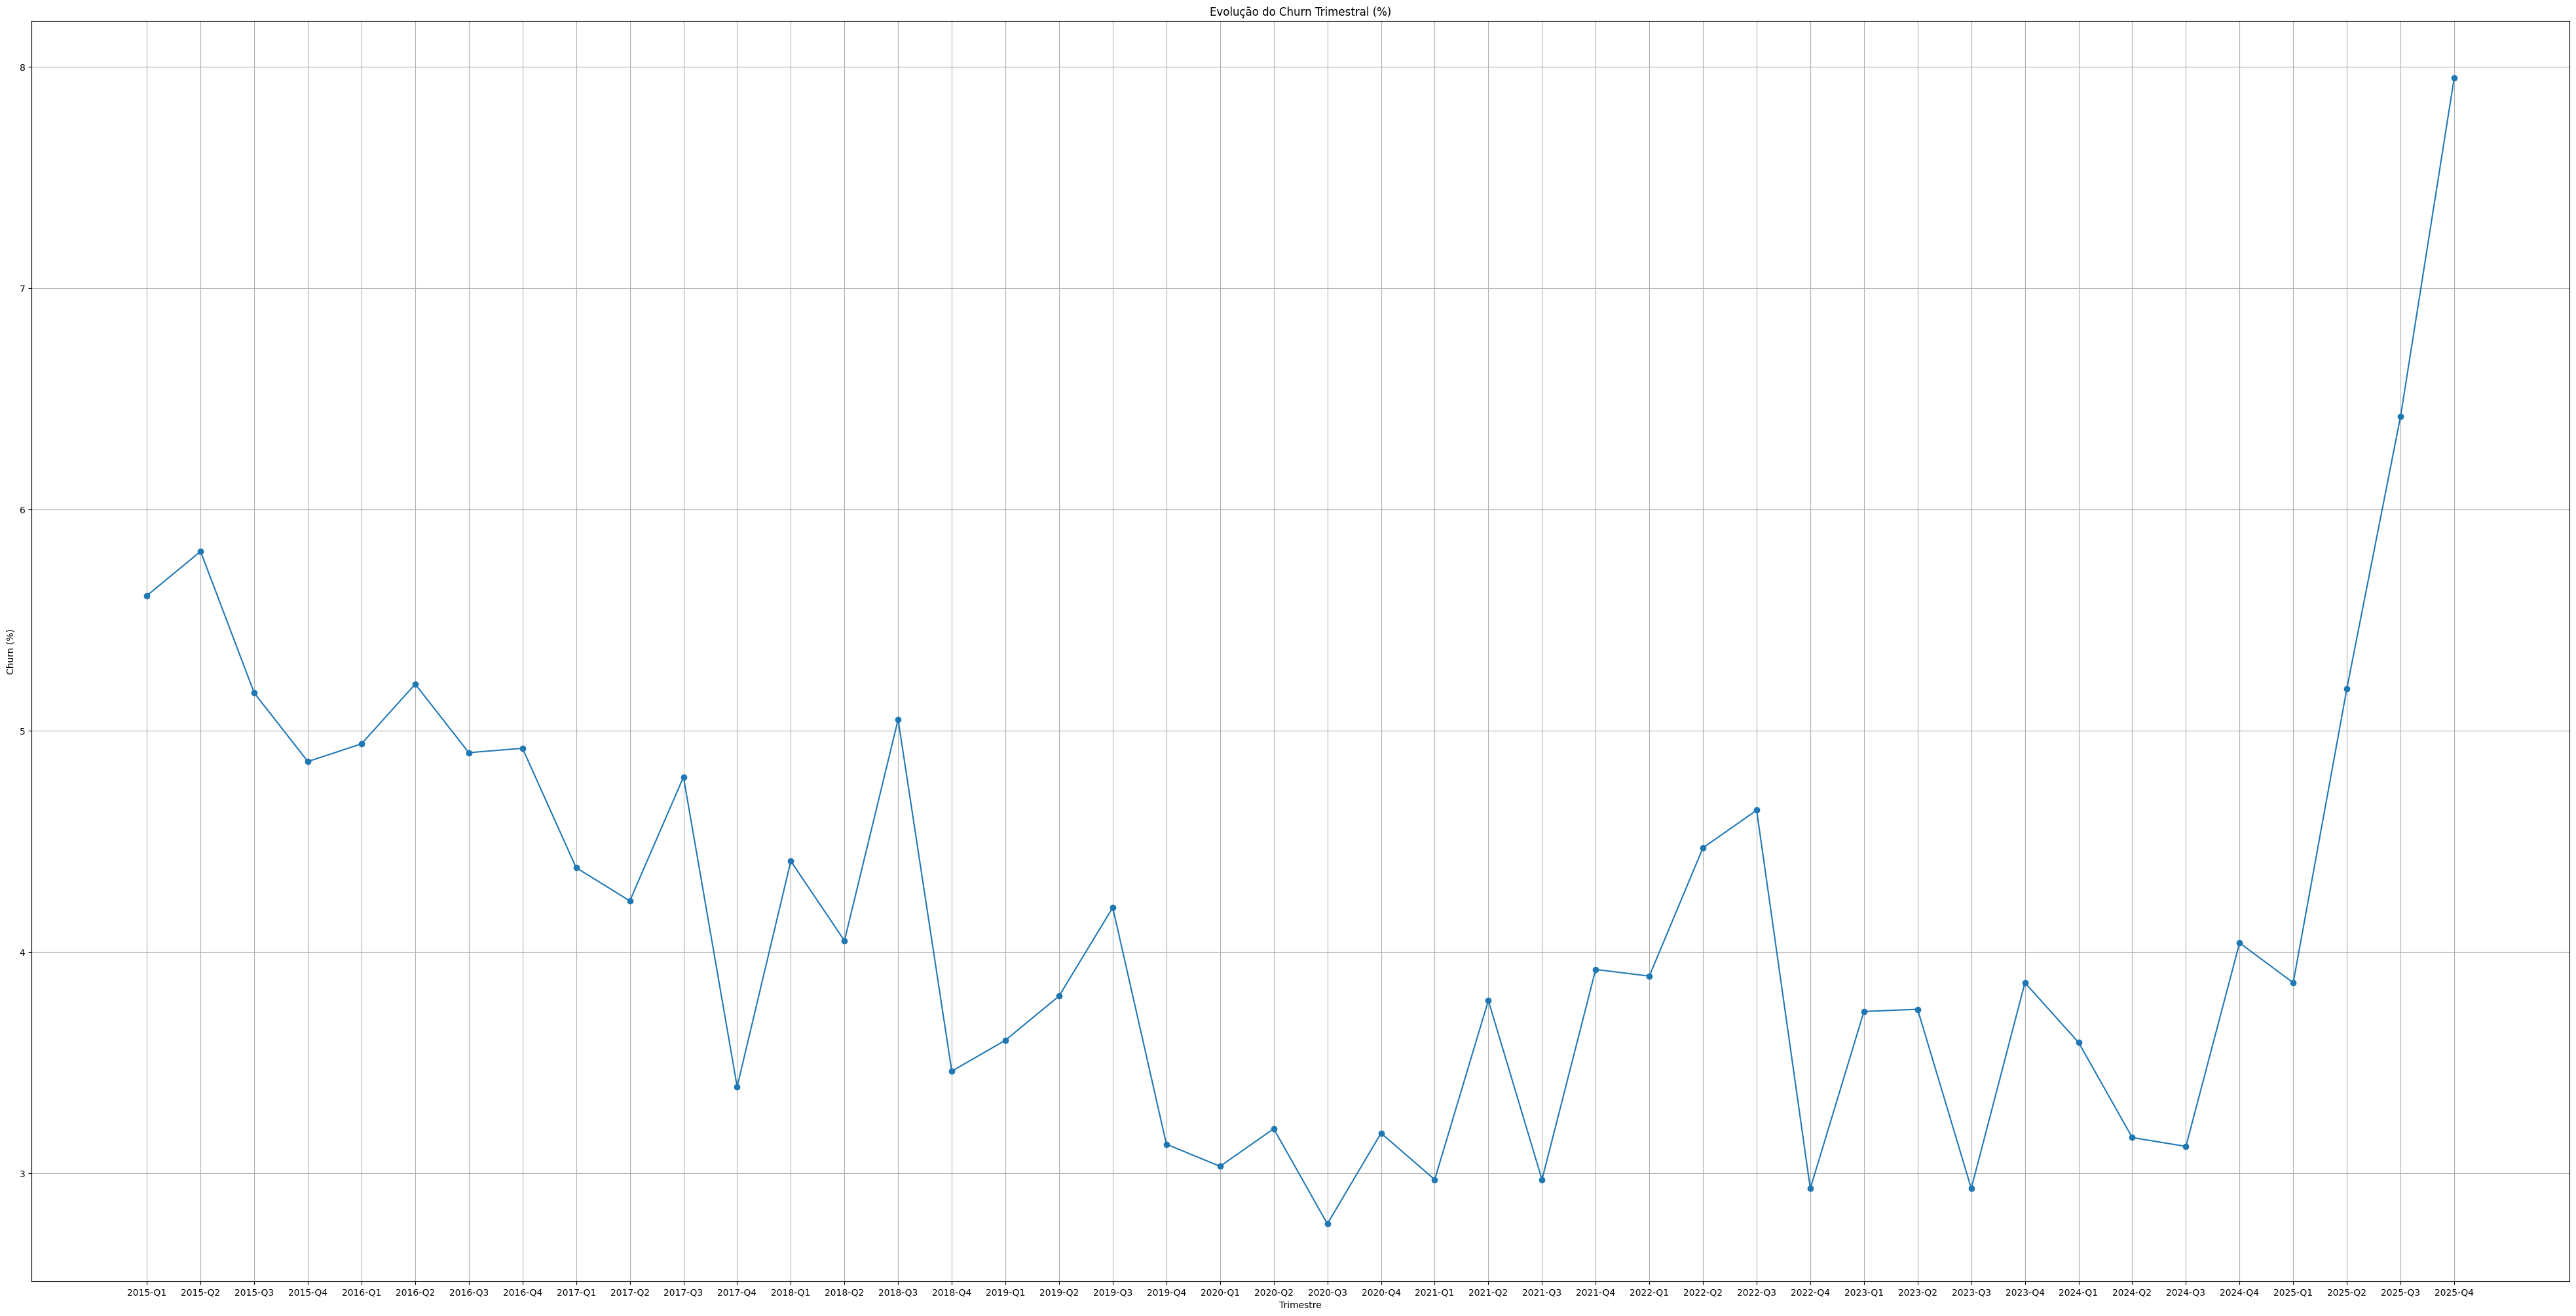

In [16]:
import pandas as pd

plt.figure(figsize=(50,25))

plt.plot(
    df_churn_trimestral["periodo_trimestral"],
    df_churn_trimestral["churn_rate_trimestral_percentual"],
    marker="o"
)

plt.title("Evolução do Churn Trimestral (%)")
plt.xlabel("Trimestre")
plt.ylabel("Churn (%)")
plt.grid(True)

plt.show()

In [17]:
# Média e Mediana 
media_trimestral = df_churn_trimestral['churn_rate_trimestral_percentual'].mean()
mediana_trimestral = df_churn_trimestral['churn_rate_trimestral_percentual'].median()
print(mediana_trimestral)
print(media_trimestral)

3.9050000000000002
4.1647727272727275


### Analises mais Profundas

In [20]:
import pandas as pd
import numpy as np

# 2. Estatísticas de Dispersão (Volatilidade)
desvio_padrao = df_churn_trimestral['churn_rate_trimestral_percentual'].std()
cv = (desvio_padrao / media_trimestral) * 100  # Coeficiente de Variação
amplitude = df_churn_trimestral['churn_rate_trimestral_percentual'].max() - df_churn_trimestral['churn_rate_trimestral_percentual'].min()

# 3. Identificação de Outliers (Z-Score)
# O Z-score diz quantos desvios padrão um ano está longe da média
df_churn_trimestral['z_score'] = (df_churn_trimestral['churn_rate_trimestral_percentual'] - media_trimestral) / desvio_padrao

# Exibindo os resultados formatados
print(f"--- Diagnóstico Estatístico do Churn ---")
print(f"Média Histórica: {media_trimestral:.2f}%")
print(f"Mediana Histórica: {mediana_trimestral:.2f}%")
print(f"Desvio Padrão (Sigma): {desvio_padrao:.2f}")
print(f"Amplitude (Max-Min): {amplitude:.2f}%")
print(f"Coeficiente de Variação: {cv:.2f}%")
print("-" * 40)

# Filtrando anomalias (Z-Score > 1.5 ou < -1.5)
anomalias = df_churn_trimestral[df_churn_trimestral['z_score'].abs() > 1.5]
print("Anos com comportamento fora do padrão (Anomalias):")
print(anomalias[['periodo_trimestral', 'churn_rate_trimestral_percentual', 'z_score']])

--- Diagnóstico Estatístico do Churn ---
Média Histórica: 4.16%
Mediana Histórica: 3.91%
Desvio Padrão (Sigma): 1.06
Amplitude (Max-Min): 5.18%
Coeficiente de Variação: 25.40%
----------------------------------------
Anos com comportamento fora do padrão (Anomalias):
   periodo_trimestral  churn_rate_trimestral_percentual   z_score
1             2015-Q2                              5.81  1.555225
42            2025-Q3                              6.42  2.131855
43            2025-Q4                              7.95  3.578156


# 📊 Relatório de Diagnóstico Estatístico: Churn Trimestral

## 1. Visão Geral (Média vs. Mediana)
O objetivo desta análise é identificar se o comportamento recente do Churn é uma oscilação comum ou uma anomalia estrutural.

* **Média Histórica:** Representa o "piso" esperado do churn.
* **Mediana:** Como o gráfico apresenta um pico súbito no final, a **Mediana** provavelmente estará abaixo da média, indicando que o comportamento histórico era mais saudável do que o cenário atual sugere.

---

## 2. Volatilidade e Dispersão
Utilizamos o **Coeficiente de Variação (CV)** para medir o risco e a previsibilidade:

* **Baixa Volatilidade (CV < 15%):** Indica um churn previsível e sob controle.
* **Alta Volatilidade (CV > 15%):** O gráfico mostra que até 2023 o churn era estável, mas a subida vertical em 2025 disparará este indicador, sinalizando instabilidade operacional.
* **Amplitude:** A diferença entre o mínimo (~2.8% em 2020) e o máximo (>7% em 2025) mostra que o negócio está operando em extremos nunca vistos antes.

---

## 3. Detecção de Anomalias (Z-Score)
O **Z-Score** mede quantos desvios padrão um ponto está longe da média. No seu código, definimos o corte em **1.5**:

| Z-Score | Interpretação | Status no Gráfico |
| :--- | :--- | :--- |
| **Z < -1.5** | Anomalia Positiva | Período de retenção excepcional (ex: meados de 2020). |
| **|Z| < 1.5** | Normalidade | Flutuações comuns de mercado (2021 a 2023). |
| **Z > 1.5** | **Anomalia Crítica** | O salto drástico observado em **2025**. |

---

## 4. Conclusão do Diagnóstico
Os dados indicam que o churn atual (acima de 7%) é uma **anomalia estatística severa**. Não se trata de ruído estatístico, mas de uma tendência de saída acelerada que rompeu o padrão de confiança dos últimos 5 anos.

**⚠️ Recomendações:**
1. Investigar mudanças de preço ou perda de diferencial competitivo em 2024/2025.
2. Validar se a base de clientes (denominador) não sofreu uma queda abrupta.